In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from photutils.background import Background2D \
                                 ,MedianBackground
from photutils.segmentation import detect_sources\
                                 ,detect_threshold,deblend_sources\
                                 ,SourceCatalog
from photutils.isophote import EllipseGeometry,Ellipse
from photutils.aperture import EllipticalAperture

# Definición de Funciones 

* Definición de funciones generadoras 


In [ ]:
def generador_map(data,nsigma=10):
    '''
    Función para generar el mapa simple de las fuentes para 
    cada data suministrada.
    -----------------------------------------------------------------------
    * data: array suministrado al que se le busca obtener su mapa 
    * nsigma: El número de desviaciones estándar por píxel por encima del 
              fondo para el cual se considera que un píxel posiblemente 
              forma parte de una fuente.
              
    '''
    data_threshold = detect_threshold(data,nsigma)
    mapa = detect_sources(data,data_threshold,nsigma)
    
    return mapa


def generador_segment_map(data,mapa):
    '''
    Función para generar el mapa de las fuentesseparadas para cada data 
    suministrada con deblend aplicado. Función que requiere información que 
    se extrae del uso de "generador_mapa", obteniendo "mapa"
    -----------------------------------------------------------------------
    * data: array al que uno busca obtener las fuentes separadas aunque 
            parescan la misma fuente o estén sobrepuestas 
    * mapa: con el mapa suministramos la información de las primeras 
            fuentes que están mezcladas
    '''
    segment_mapa = deblend_sources(data, mapa,npixels=10, nlevels=32,\
                                   contrast=0.001,progress_bar=False)
    
    return segment_mapa


def generar_tablas(data,segment_map_data):
    '''
    Función para obtener las tablas para cada data suministrado. Requiere el 
    uso de información extraida de la función "generador_segment_map", o sea 
    el mapa segmentado.
    ------------------------------------------------------------------------
    * data: array del que buscamos las fuentes para crear la tabla
    * segment_map_data: con el segment_map podemos diferenciar las fuentes 
                        para ingresarlas en la tabla
    '''
    data_catalogo = SourceCatalog(data,segment_map_data)
    data_tabla = data_catalogo.to_table()
    
    return data_tabla


def generar_catologo(data,segment_map_data):
    '''
    Función para obtener los catalogos para cada data suministrado. Requiere 
    el uso de información extraida de la función "generador_segment_map", o 
    sea el mapa segmentado.
    ------------------------------------------------------------------------
    * data: array del que buscamos las fuentes para crear el catalgo
    * segment_map_data: con el segment_map podemos diferenciar las fuentes 
                        para ingresarlas al catalogo
    '''
    data_catalogo = SourceCatalog(data,segment_map_data)
        
    return data_catalogo


def generador_de_geometria_isofotas(x,y,semi_eje_mayor,epsilon,angulo):
    '''
    Función para generar la forma de una Elpise con centro (x,y) y una 
    excentricidad gual a epsilon en la imagen, con un semi eje major en 
    pixeles rotado un angulo con respecto al eje x del grafico.
    -------------------------------------------------------------------
    * (x,y): centro de la elipse
    * semi_eje_mayor: distnacia en pixeles del semi eje mayor de la 
                      elipse
    * epsilon: excentricidad de la elipse 
    * angulo: angulo entre el semi eje mayor y el eje x del gráfico
    '''
    geometry = EllipseGeometry(x0=x,y0=y,sma=semi_eje_mayor,eps=epsilon,\
                               pa=(angulo*np.pi)/180.0)
    return geometry


def generador_de_una_apertura (geometría_isofota): 
    '''
    Función que nos ayuda a generar una apertura en pixeles de la 
    isofota entregada, esto con el fin de graficarla por sobre la imagen.
    ---------------------------------------------------------------------
    * geometría_isofota: forma que contiene toda la información de la
                         elipse.
    '''
    apertura = EllipticalAperture((geometría_isofota.x0, \
                                   geometría_isofota.y0),\
                                   geometría_isofota.sma,\
                                   geometría_isofota.sma \
                                  * (1 - geometría_isofota.eps),
                                   geometría_isofota.pa)
    return apertura


def generar_varias_aperturas(f,i):
    '''
    Función que nos ayuda a generar varias aperturas en pixeles de la 
    isofota entregada, esto con el fin de usar esta información para
    graficarla por sobre la imagen de la data a que corresponda.
    -----------------------------------------------------------------
    * f: función que contiene varias isofotas correspondientes a un
         objeto
    * i: el numero de esa isofota. Por ejemplo, i=0 corresponde a la
         la primera isofota del objeto.
    '''
    return  EllipticalAperture((f.x0[i], f.y0[i]), f.sma[i],\
                               f.sma[i] * (1 - f.eps)[i],f.pa[i])
   

def generador_de_isofotas (data,geometria_isofota_data):
    '''
    Función que nos ayuda a ajustar una isofota de la data sobre una 
    imagen de la data.
    -----------------------------------------------------------------
    * data: imagen de la cual buscamos las isofotas
    * geometria_isofota_data: forma de la primera isofota que nos 
                              ayuda a orientar al resto de isofotas
    '''
    return Ellipse(data,geometria_isofota_data).fit_image()


* Definicion de funciones graficadoras 

In [3]:
def grafricar_1(data,title):
    '''
    Función para para graficar 1 arreglo suministrado.
    ------------------------------------------------------------------------
    * data: array a graficar que corresponde a una imagen 
    * title: titulo correspondiente al array 
    '''
    plt.figure(figsize=(5,5))
    plt.imshow(data,interpolation='nearest',origin='lower',\
               vmax=np.mean(data)+np.std(data))
    plt.title(title,fontsize=7,y=1.04)
    
    plt.show()
    


def graficar_2(data_1,data_2,title_1="plot",title_2="plot"):
    '''
    Función para graficar los arreglos que estemos trabajando, adaptada para 
    colocar los títulos a los gráficos.
    ------------------------------------------------------------------------
    * data_1: primer array a graficar que corresponde a una imagen 
    * data_2: segundo array a graficar que corresponde a una imagen 
    * title_1: titulo correspondiente al primer array 
    * title_2: titulo correspondiente al segundo array 
    '''
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(data_1,cmap=data_1.cmap,\
                 interpolation='nearest',origin='lower')
    ax[0].set_title(title_1,fontsize=7,y=1.04)
    ax[1].imshow(data_2,cmap=data_2.cmap,\
                 interpolation='nearest',origin='lower')
    ax[1].set_title(title_2,fontsize=7,y=1.04)
    plt.show


def graficar_rgb_con_y_sin_fuentes(data_1,data_2,data_3,data_4,\
                                   title_1='plot',title_2='plot'):
    '''
    Función para graficar los arreglos que estemos trabajando, adaptada para 
    colocar los títulos a los gráficos y marcar las fuentes correspondietes 
    de cada data suministrada.
    ------------------------------------------------------------------------
    * data_1: array a graficar correspondiete a una imagen
    * data_2: array a graficar que corresponde a las fuentes en la primera 
              banda
    * data_3: array a graficar que corresponde a las fuentes en la segunda 
              banda
    * data_4: array a graficar que corresponde a las fuentes en la tercera
              banda
    * title_1: titulo del primer grafico 
    * title_2: titulo del segundo grafico 
    '''
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(data_1,vmin=0, vmax=np.mean(data_1)+np.std(data_1),\
                 interpolation='nearest',origin='lower')
    ax[0].set_title(title_1,fontsize=7,y=1.04)
    ax[1].imshow(data_1,vmin=0, vmax=np.mean(data_1)+np.std(data_1),\
                 interpolation='nearest',origin='lower')
    ax[1].set_title(title_2,fontsize=7,y=1.04)
    data_2.plot_kron_apertures(color='red', lw=1.5)
    data_3.plot_kron_apertures(color='green', lw=1.5)
    data_4.plot_kron_apertures(color='hotpink', lw=1.5)


def graficar_varias_isofotas(objeto,isofotas_objeto,archivo,\
                             cota_inferior,cota_superior,title='plot'):
    '''
    Función para graficar los arreglos que estemos trabajando, adaptada para 
    colocar los títulos a los gráficos y graficar las isofotas 
    correspondietes del objeto suministrado.
    ------------------------------------------------------------------------
    * objeto: array que contiene al objeto aislado para graficarles por 
              encima las isofotas 
    * isofotas_objeto: array que contiene la informacion de las variadas 
                       isofotas del objeto 
    * archivo: archivo del cual se sustrae el objeto, se usa para limpiar el
               el fondo y que sea más visible 
    * cota_inferior y cota_superior: cotas en las cuales se escogen las 
                                     isofotas 
    * title: titulo del grafico 
    '''
    plt.figure(figsize=(5,5))
    plt.imshow(objeto, origin='lower',vmax=np.mean(archivo)+np.std(archivo))
    plt.title(title)
    for i in range (cota_inferior,cota_superior,2):
        generar_varias_aperturas(isofotas_objeto,i).plot(color='hotpink')

# Trabajo 

* Link utilizado:"https://www.legacysurvey.org/viewer/fits-cutout?ra=0.7170&dec=13.4332&layer=ls-dr10&pixscale=0.262&bands=grz&size=1024 "
* Con "RA=0.7170" y con "DC=13.4332"

In [7]:
archivos_fits = fits.open('Imagen_TG_4.fits')

* Abrimos el fits y lo asociamos en una variable.

In [8]:
archivos_fits.info()

Filename: Imagen_TG_4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   (1024, 1024, 3)   float32   


* Ya abierto el fits, asociamos una variable para extraer la información de este mismo.

In [9]:
archivos_array = np.array(archivos_fits[0].data)

* Separamos la información por cada filtro 

In [10]:
archivos_array_g = archivos_array[0,:,:]

In [11]:
archivos_array_r = archivos_array[1,:,:]

In [12]:
archivos_array_z = archivos_array[2,:,:]

* Ocupamos la función "generador_map" para obtener el mapa de fuentes  

In [13]:
g_mapa = generador_map(archivos_array_g)
print(g_mapa)

<photutils.segmentation.core.SegmentationImage>
shape: (1024, 1024)
nlabels: 58
labels: [ 1  2  3  4  5 ... 54 55 56 57 58]


In [14]:
r_mapa = generador_map(archivos_array_r)
print(r_mapa)

<photutils.segmentation.core.SegmentationImage>
shape: (1024, 1024)
nlabels: 73
labels: [ 1  2  3  4  5 ... 69 70 71 72 73]


In [15]:
z_mapa = generador_map(archivos_array_z)
print(z_mapa)

<photutils.segmentation.core.SegmentationImage>
shape: (1024, 1024)
nlabels: 71
labels: [ 1  2  3  4  5 ... 67 68 69 70 71]


* Ahora usamos la función "generador_segment_map" para obtener el mapa usando el deblend 

In [16]:
G_segment_mapa = generador_segment_map(archivos_array_g, g_mapa)
print(G_segment_mapa)

<photutils.segmentation.core.SegmentationImage>
shape: (1024, 1024)
nlabels: 90
labels: [ 1  2  3  4  5 ... 86 87 88 89 90]


In [17]:
R_segment_mapa = generador_segment_map(archivos_array_r, r_mapa)
print(R_segment_mapa)

<photutils.segmentation.core.SegmentationImage>
shape: (1024, 1024)
nlabels: 106
labels: [  1   2   3   4   5 ... 102 103 104 105 106]


In [18]:
Z_segment_mapa = generador_segment_map(archivos_array_z, z_mapa)
print(Z_segment_mapa)

<photutils.segmentation.core.SegmentationImage>
shape: (1024, 1024)
nlabels: 87
labels: [ 1  2  3  4  5 ... 83 84 85 86 87]


* Ya teniendo los mapas y los mapas segmentados vamos a graficar 

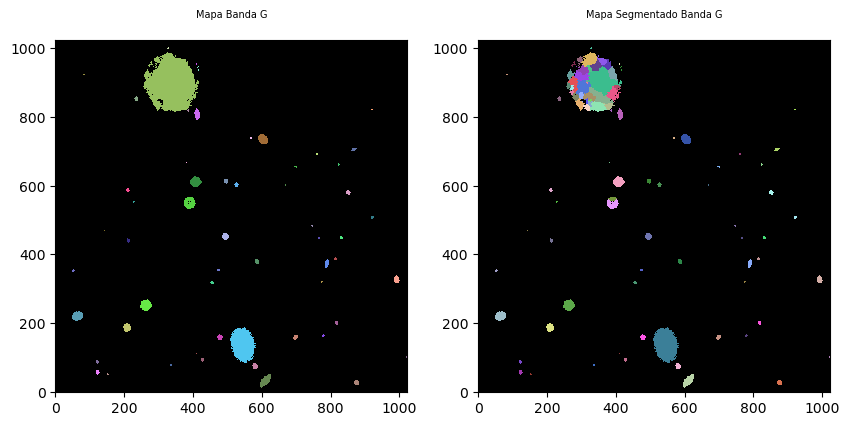

In [19]:
graficar_2(g_mapa,G_segment_mapa,'Mapa Banda G','Mapa Segmentado Banda G')

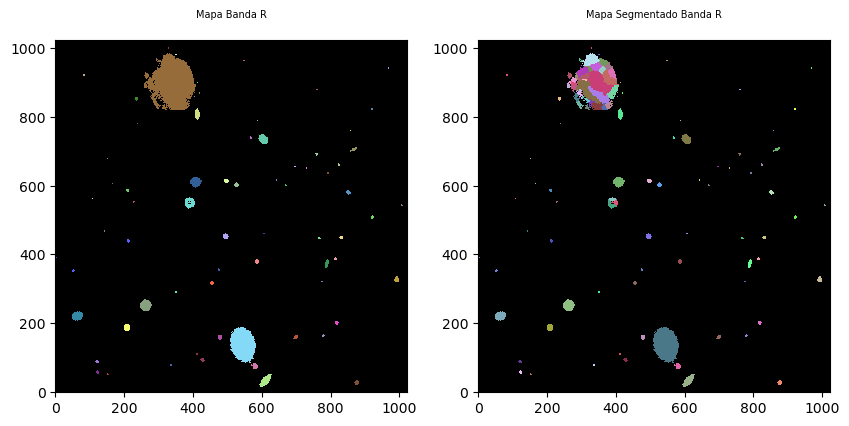

In [20]:
graficar_2(r_mapa,R_segment_mapa,'Mapa Banda R','Mapa Segmentado Banda R')

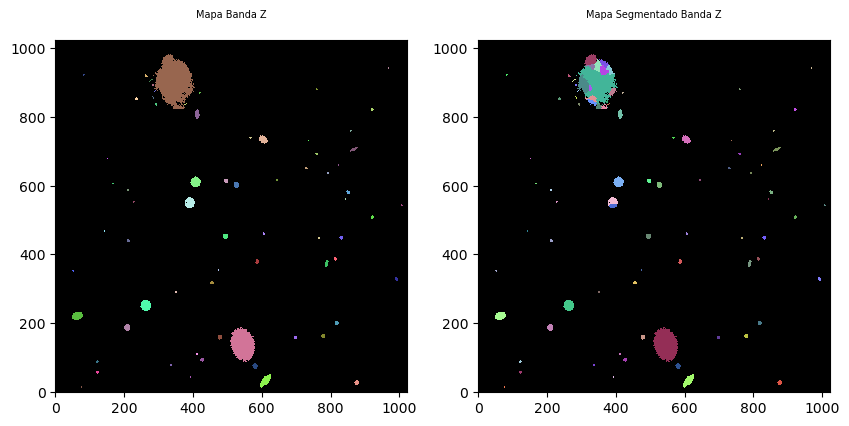

In [21]:
graficar_2(z_mapa,Z_segment_mapa,'Mapa Banda Z','Mapa Segmentado Banda Z')

* Ya teniendo los datos y viendo sus resultados, generemaos las tablas para cada banda con la función "generar_tablas()".

In [22]:
generar_tablas(archivos_array_g,G_segment_mapa)

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int32,float64,float64,object,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,610.7963020105041,32.590987559568276,None,593,628,13,51,760.0,7.574205901371133,3.6882228688130523,48.44623725176432,0.8734325479069741,0.021620269864797592,0.9095063209533691,0.0,78.95212309993804,nan,92.62712252828572,nan
2,874.5616437452461,26.778098661020238,None,868,882,19,34,189.0,2.505892650336453,2.2681817220123106,-79.1101800334659,0.4251152669460087,0.022068211808800697,1.5932645797729492,0.0,46.9882887173444,nan,47.51023992715632,nan
3,152.91833940656616,50.49632482071713,None,150,156,48,53,33.0,1.48262977545803,1.410293174478708,-43.440431763589615,0.3085423369279014,0.022501405328512192,0.0735127404332161,0.0,1.3438767567276955,nan,2.319606790469258,nan
4,123.29099397941233,56.87807003562766,None,118,129,50,63,128.0,2.3455594610148642,2.0883033348288116,-79.87660724974064,0.45533133728067066,0.022101080045104027,0.662554919719696,0.0,18.878965437412262,nan,19.984165172554675,nan
5,579.919820522103,74.6611734107151,None,571,589,66,83,232.0,3.394957207006371,3.0437909336062554,-58.540136922989035,0.4429174733010411,0.021591363474726677,0.3219612240791321,0.0,17.226446479558945,nan,32.111551906273114,nan
6,335.2849926574688,78.39341541859004,None,333,338,76,81,30.0,1.4579573514974173,1.3125800172126674,-51.03625582792261,0.4352968622171666,0.021913301199674606,0.06823490560054779,0.0,1.2229719702154398,nan,2.132695550609779,nan
7,121.83597629995117,87.12259944830731,None,116,127,82,92,87.0,2.5309962492423597,2.336566543157226,-58.99380898742757,0.3843665535565658,0.021581972017884254,0.05594729259610176,0.0,2.9786592796444893,nan,7.051672136722662,nan
8,544.2957007805649,136.6043070698404,None,508,583,84,187,5521.0,17.58280695030084,12.16735992630595,-78.1977494614006,0.7218943639222384,0.02152315154671669,1.3433983325958252,0.0,434.1308217551559,nan,583.355576132119,nan


In [23]:
generar_tablas(archivos_array_r,R_segment_mapa)

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int32,float64,float64,object,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,610.8344767093434,32.71641960185289,None,593,628,14,52,766.0,7.546179308282399,3.454837919158669,47.861799163848964,0.8890417610385826,0.04945957660675049,2.9673614501953125,0.0,196.6137436851859,nan,221.85765293869372,nan
2,874.5779357401747,26.86506845828385,None,868,881,20,33,157.0,2.0697806166195973,1.9448355215729811,-58.33765900210392,0.34218211272333354,0.049876466393470764,5.896163463592529,0.0,116.39385432749987,nan,116.19377049448747,nan
3,152.8735205424209,50.69878611150187,None,151,155,48,53,22.0,1.205121295855876,1.1698250943514583,-77.51886356194488,0.24024819276641837,0.050295840948820114,0.1490785777568817,0.0,1.9609277360141277,nan,3.379298059569985,nan
4,123.36011112613905,57.08146918811938,None,119,128,52,62,84.0,1.8605308657358577,1.6967421196224584,-54.49909008113221,0.4102643183136657,0.04983028024435043,1.494726300239563,0.0,27.893310703337193,nan,29.358354088321388,nan
5,579.8585413772555,74.7978503280755,None,570,588,67,84,224.0,3.2546967871955395,2.784357917632476,-50.15297571348042,0.5178206698052571,0.04957157373428345,1.119238257408142,0.0,43.17298933491111,nan,69.67623585922493,nan
6,335.2434874055336,78.41295004076053,None,333,338,75,81,33.0,1.4412929823233271,1.2874022057717038,-63.48092533831936,0.44960541795712305,0.05071181431412697,0.2918832302093506,0.0,4.3916168212890625,nan,5.926527209920067,nan
7,121.92852378742118,87.31158482904834,None,117,127,83,92,82.0,2.4952156452906737,2.1452066209174117,-48.439018580299475,0.5107522484575849,0.04950866475701332,0.1582503467798233,0.0,7.112325485795736,nan,15.775078655283972,nan
8,544.2309998268529,136.7302963823555,None,507,582,84,190,5841.0,17.748047783377416,12.304570234569734,-77.68481868908903,0.7206572902782986,0.04942029342055321,4.192175388336182,0.0,1115.7649440430105,nan,1446.0092771642676,nan


In [24]:
generar_tablas(archivos_array_z,Z_segment_mapa)

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int32,float64,float64,object,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,610.8641897034738,32.58205740726363,None,594,627,11,51,707.0,7.413259447219578,3.456968218100137,48.064900875771215,0.8846148934608795,0.10862623900175095,5.310688495635986,0.0,366.1518509835005,nan,426.36459811042084,nan
2,76.86463279817501,13.980360222622243,None,75,79,12,16,15.0,1.1434506033746425,0.9725680406181418,89.19151230982429,0.5258855180112312,0.11323164403438568,0.1875024437904358,0.0,2.1067855581641197,nan,8.19069428786312,nan
3,874.6163349009689,26.878503014624016,None,868,881,20,34,157.0,2.2029539430382274,2.060029225153985,-68.20983360970565,0.35432766583139935,0.11235466599464417,7.995739936828613,0.0,173.83926463872194,nan,175.58565601266417,nan
4,392.5681311761454,43.158461937929765,None,391,395,41,45,18.0,1.2093285852433717,1.0721736103662458,-62.11953192857544,0.4625640847516073,0.11464233696460724,0.21023264527320862,0.0,2.7651765272021294,nan,7.98990702839758,nan
5,123.35600097210484,57.07607728710049,None,120,127,53,61,60.0,1.765581201972555,1.5703268151766945,-70.04587590937288,0.4571089632504414,0.11448400467634201,1.5479967594146729,0.0,28.627347491681576,nan,33.011915123922115,nan
6,579.944464128314,74.75763873463195,None,572,587,67,83,191.0,3.081560560111138,2.681794286057378,-59.533941105237645,0.4925723720085467,0.10869961977005005,1.9716403484344482,0.0,76.85221169143915,nan,129.64335813608804,nan
7,335.17589174164,78.37808064942534,None,333,338,76,81,28.0,1.3683975923459788,1.2276227339655128,-68.87584035758334,0.44177821129572664,0.11576276272535324,0.4719898998737335,0.0,6.786137856543064,nan,10.001949044551981,nan
8,121.9447974997855,87.14091383630426,None,118,126,83,92,59.0,2.1192627263245116,1.9215549604089406,-67.82318192937453,0.4217564108291505,0.10876605659723282,0.271380215883255,0.0,9.765364095568657,nan,26.218818882523465,nan


* Ahora para graficar las fuentes, necesitamos generar el catalogo para cada banda y generar la imagen en RGB. Para esto usamos la función "generar_catologo()".

In [29]:
imagen_RGB = make_lupton_rgb(archivos_array_z,archivos_array_r,\
                             archivos_array_g,stretch=0.1,Q=10)

In [30]:
G_catalogo = generar_catologo(archivos_array_g,G_segment_mapa)

In [31]:
R_catalogo = generar_catologo(archivos_array_r,R_segment_mapa)

In [32]:
Z_catalogo = generar_catologo(archivos_array_z,Z_segment_mapa)

* Ya teniendo los catalogos respectivos y la imagen RGB, ocupando la función "graficar_rgb_con_y_sin_fuentes()", ploteamos la imagen en RGB y otra con las fuentes marcadas  

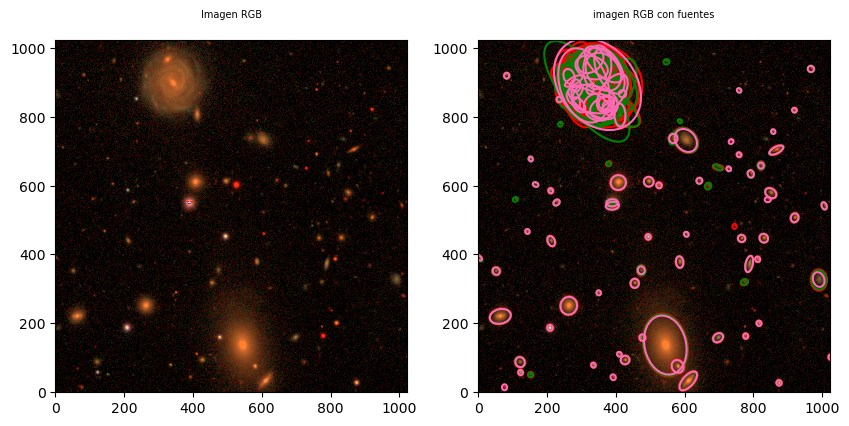

In [34]:
graficar_rgb_con_y_sin_fuentes(imagen_RGB,G_catalogo,\
                               R_catalogo,Z_catalogo,\
                               'Imagen RGB','imagen RGB con fuentes')

# Isofotas 

* Hacemos un acercamiento a la imagen en algun filtro en especifico, en este caso usaremos la banda g

* Isofotas del Objeto 1

In [35]:
Objeto_1 = archivos_array_g[800:1000,225:425]

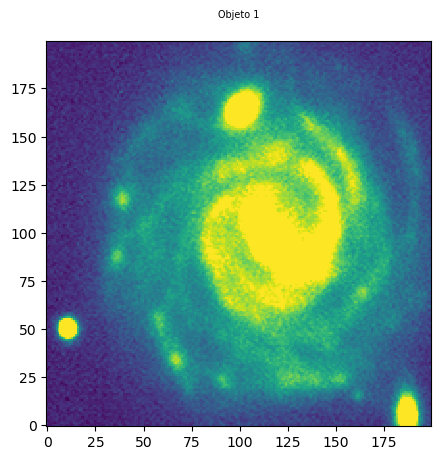

In [36]:
grafricar_1(Objeto_1,'Objeto 1')

* Generamos una elipse de prueba que se acomode al objeto y la graficamos para observar su coincidencia 

In [37]:
Elipse_Prueba_O_1 = generador_de_geometria_isofotas(117.2,96.7,21,0.5,120)

(<matplotlib.patches.Ellipse at 0x213bea814f0>,)

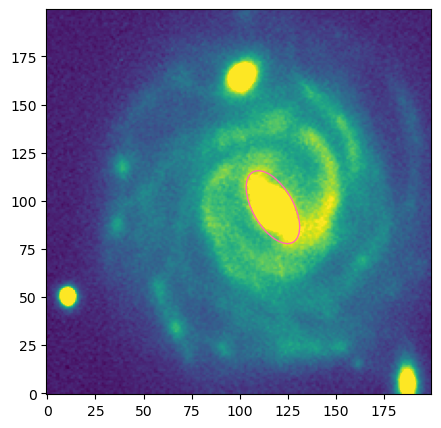

In [38]:
apertura_O_1 = generador_de_una_apertura(Elipse_Prueba_O_1)
plt.figure(figsize=(5,5))
plt.imshow(Objeto_1, origin='lower',\
           vmax=np.mean(archivos_array_g)+np.std(archivos_array_g))
apertura_O_1.plot(color='hotpink')

* Ya teniendo una idea de como es la primera isofota, usando "Ellipse" de "photutils.isophote" en conjunto a la geometría de esta y todo esto iterado un par de veces, obtenemos una visualización de variadas isofotas para el objeto. 

In [39]:
Lista_isofotas_obj_1 = generador_de_isofotas(Objeto_1,Elipse_Prueba_O_1)

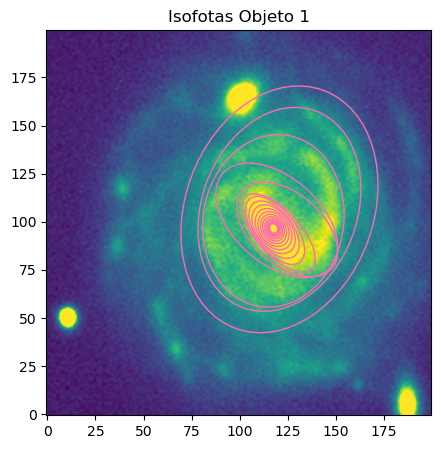

In [40]:
graficar_varias_isofotas(Objeto_1,Lista_isofotas_obj_1,\
                         archivos_array_g,18,54,'Isofotas Objeto 1')

* Isofotas del Objeto 2

In [41]:
Objeto_2 = archivos_array_g[0:300,390:690]

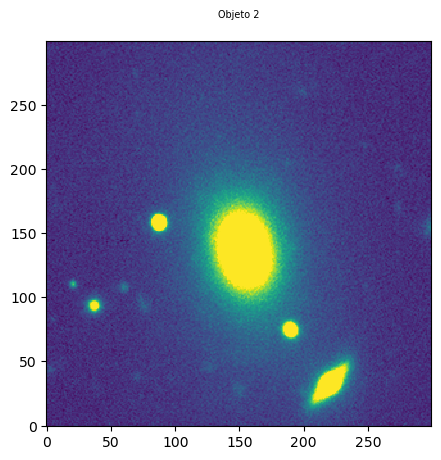

In [42]:
grafricar_1(Objeto_2,'Objeto 2')

* Generamos una elipse de prueba que se acomode al objeto y la graficamos para observar su coincidencia 

In [43]:
Elipse_Prueba_O_2 = generador_de_geometria_isofotas(154,138,25,0.385,100)

(<matplotlib.patches.Ellipse at 0x213bd7048e0>,)

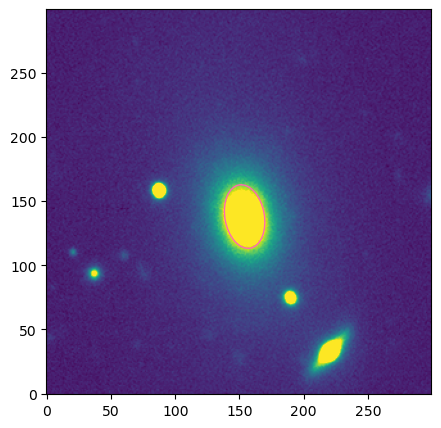

In [44]:
apertura_O_2 = generador_de_una_apertura(Elipse_Prueba_O_2)
plt.figure(figsize=(5,5))
plt.imshow(Objeto_2, origin='lower',\
           vmax=np.mean(archivos_array_g)+np.std(archivos_array_g))
apertura_O_2.plot(color='hotpink')

* Ya teniendo una idea de como es la primera isofota, usando "Ellipse" de "photutils.isophote" en conjunto a la geometría de esta y todo esto iterado un par de veces, obtenemos una visualización de variadas isofotas para el objeto. 

In [46]:
Lista_isofotas_obj_2 = generador_de_isofotas(Objeto_2,Elipse_Prueba_O_2)

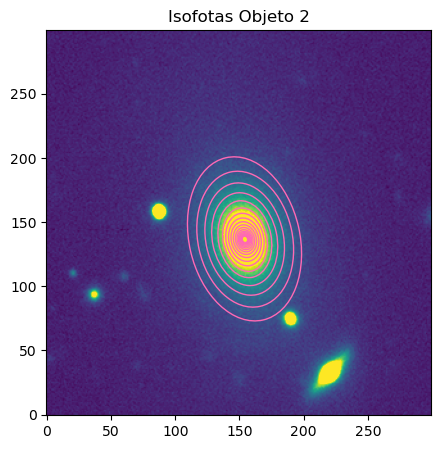

In [47]:
graficar_varias_isofotas(Objeto_2,Lista_isofotas_obj_2,\
                         archivos_array_g,18,54,'Isofotas Objeto 2')

* Isofotas del Objeto 3

In [48]:
Objeto_3 = archivos_array_g[200:300,210:310]

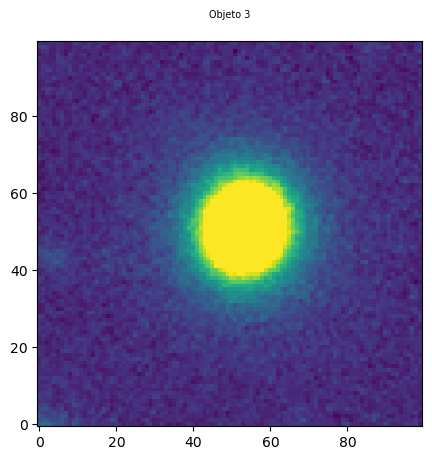

In [49]:
grafricar_1(Objeto_3,'Objeto 3')

* Generamos una elipse de prueba que se acomode al objeto y la graficamos para observar su coincidencia 

In [50]:
Elipse_Prueba_O_3 = generador_de_geometria_isofotas(53,51,10,0.1,65)

(<matplotlib.patches.Ellipse at 0x213bd155400>,)

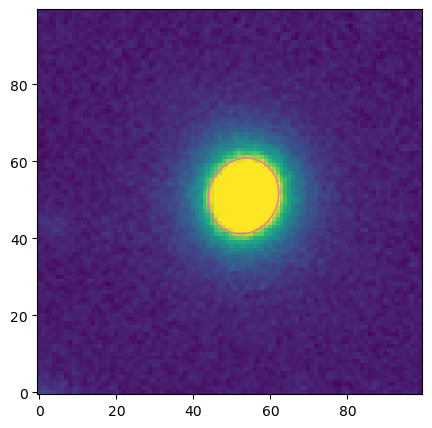

In [51]:
apertura_O_3 = generador_de_una_apertura(Elipse_Prueba_O_3)
plt.figure(figsize=(5,5))
plt.imshow(Objeto_3, origin='lower',\
           vmax=np.mean(archivos_array_g)+np.std(archivos_array_g))
apertura_O_3.plot(color='hotpink')

* Ya teniendo una idea de como es la primera isofota, usando "Ellipse" de "photutils.isophote" en conjunto a la geometría de esta y todo esto iterado un par de veces, obtenemos una visualización de variadas isofotas para el objeto. 

In [52]:
Lista_isofotas_obj_3 = generador_de_isofotas(Objeto_3,Elipse_Prueba_O_3)

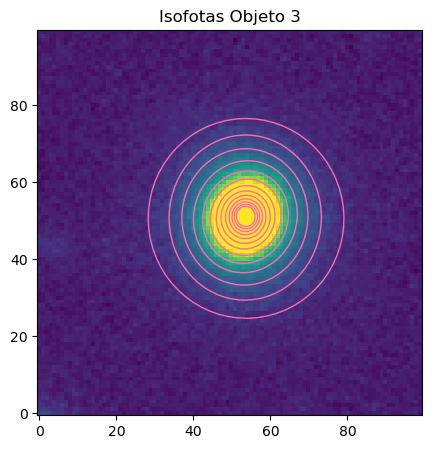

In [53]:
graficar_varias_isofotas(Objeto_3,Lista_isofotas_obj_3,\
                         archivos_array_g,18,44,'Isofotas Objeto 3')

* Isofotas del Objeto 4

In [54]:
Objeto_4 = archivos_array_g[580:640,375:435]

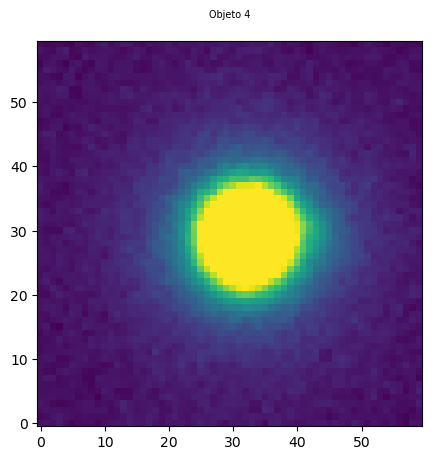

In [55]:
grafricar_1(Objeto_4,'Objeto 4')

* Generamos una elipse de prueba que se acomode al objeto y la graficamos para observar su coincidencia 

In [56]:
Elipse_Prueba_O_4 = generador_de_geometria_isofotas(32.5,29,10,0.1,65)

(<matplotlib.patches.Ellipse at 0x213bd5e0f10>,)

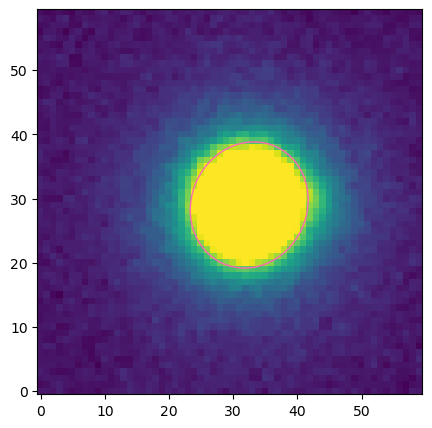

In [57]:
apertura_O_4 = generador_de_una_apertura(Elipse_Prueba_O_4)
plt.figure(figsize=(5,5))
plt.imshow(Objeto_4, origin='lower',\
           vmax=np.mean(archivos_array_g)+np.std(archivos_array_g))
apertura_O_4.plot(color='hotpink')

* Ya teniendo una idea de como es la primera isofota, usando "Ellipse" de "photutils.isophote" en conjunto a la geometría de esta y todo esto iterado un par de veces, obtenemos una visualización de variadas isofotas para el objeto. 

In [58]:
Lista_isofotas_obj_4 = generador_de_isofotas(Objeto_4,Elipse_Prueba_O_4)

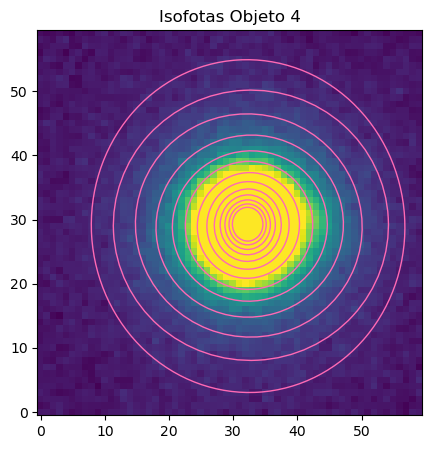

In [59]:
graficar_varias_isofotas(Objeto_4,Lista_isofotas_obj_4,\
                         archivos_array_g,18,44,'Isofotas Objeto 4')

* Isofotas del Objeto 5

In [60]:
Objeto_5 = archivos_array_z[120:220,720:820]

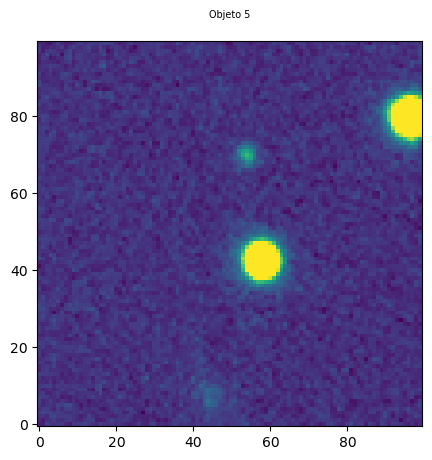

In [61]:
grafricar_1(Objeto_5,'Objeto 5')

* Generamos una elipse de prueba que se acomode al objeto y la graficamos para observar su coincidencia 

In [62]:
Elipse_Prueba_O_5 = generador_de_geometria_isofotas(57.5,42.8,6,0.05,65)

(<matplotlib.patches.Ellipse at 0x213bd714d90>,)

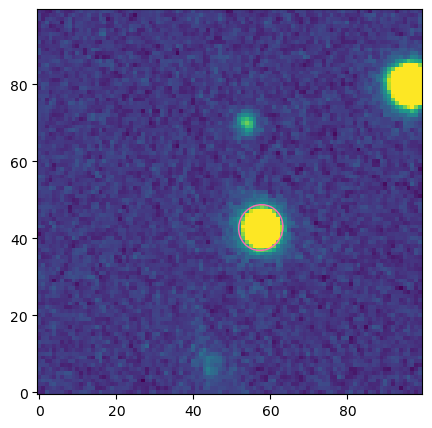

In [63]:
apertura_O_5 = generador_de_una_apertura(Elipse_Prueba_O_5)
plt.figure(figsize=(5,5))
plt.imshow(Objeto_5, origin='lower',\
           vmax=np.mean(archivos_array_z)+np.std(archivos_array_z))
apertura_O_5.plot(color='hotpink')

* Ya teniendo una idea de como es la primera isofota, usando "Ellipse" de "photutils.isophote" en conjunto a la geometría de esta y todo esto iterado un par de veces, obtenemos una visualización de variadas isofotas para el objeto. 

In [64]:
Lista_isofotas_obj_5 = generador_de_isofotas(Objeto_5,Elipse_Prueba_O_5)

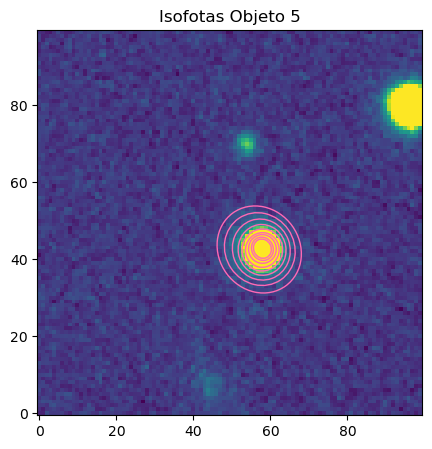

In [65]:
graficar_varias_isofotas(Objeto_5,Lista_isofotas_obj_5,\
                         archivos_array_z,18,36,'Isofotas Objeto 5')

* Isofotas del Objeto 6

In [66]:
Objeto_6 = archivos_array_g[690:790,550:650]

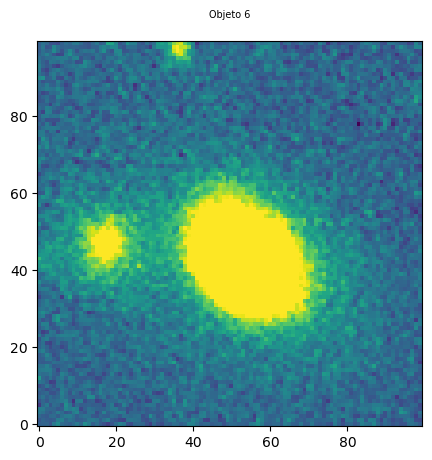

In [67]:
grafricar_1(Objeto_6,'Objeto 6')

* Generamos una elipse de prueba que se acomode al objeto y la graficamos para observar su coincidencia 

In [68]:
Elipse_Prueba_O_6 = generador_de_geometria_isofotas(54,41,7,0.4,100)

(<matplotlib.patches.Ellipse at 0x213bd679460>,)

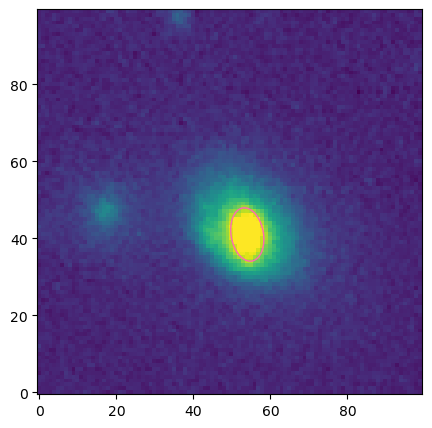

In [69]:
apertura_O_6 = generador_de_una_apertura(Elipse_Prueba_O_6)
plt.figure(figsize=(5,5))
plt.imshow(Objeto_6, origin='lower',\
           vmax=np.mean(archivos_array_g)+np.std(archivos_array_g))
apertura_O_6.plot(color='hotpink')

* Ya teniendo una idea de como es la primera isofota, usando "Ellipse" de "photutils.isophote" en conjunto a la geometría de esta y todo esto iterado un par de veces, obtenemos una visualización de variadas isofotas para el objeto. 

In [70]:
Lista_isofotas_obj_6 = generador_de_isofotas(Objeto_6,Elipse_Prueba_O_6)

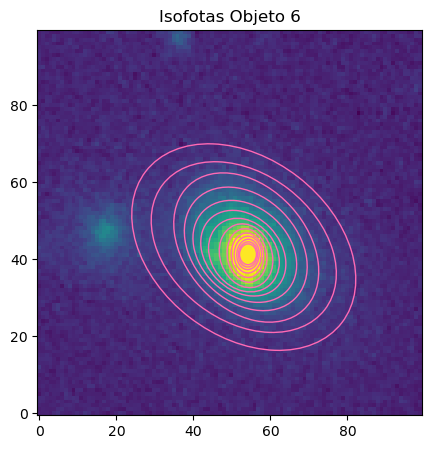

In [71]:
graficar_varias_isofotas(Objeto_6,Lista_isofotas_obj_6,\
                         archivos_array_g,18,46,'Isofotas Objeto 6')

* Isofotas del Objeto 7

In [72]:
Objeto_7 = archivos_array_g[0:100,560:660]

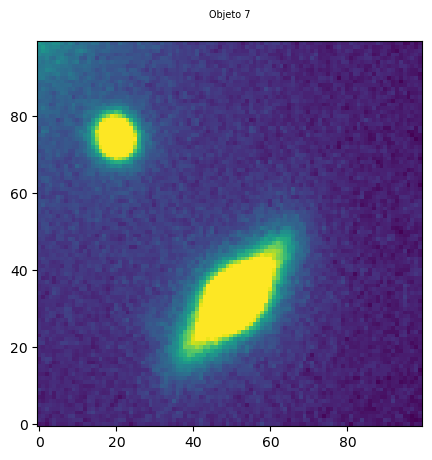

In [73]:
grafricar_1(Objeto_7,'Objeto 7')

* Generamos una elipse de prueba que se acomode al objeto y la graficamos para observar su coincidencia 

In [74]:
Elipse_Prueba_O_7 = generador_de_geometria_isofotas(51,32,13,0.4,55)

(<matplotlib.patches.Ellipse at 0x213bdbc0c70>,)

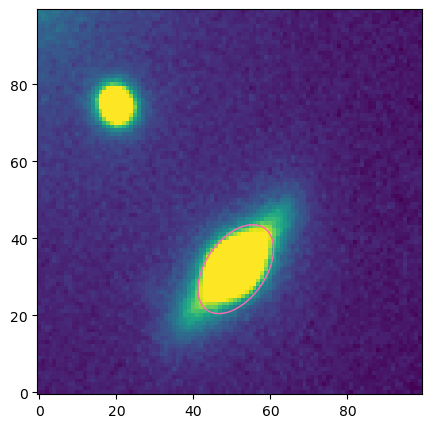

In [75]:
apertura_O_7 = generador_de_una_apertura(Elipse_Prueba_O_7)
plt.figure(figsize=(5,5))
plt.imshow(Objeto_7, origin='lower',\
           vmax=np.mean(archivos_array_g)+np.std(archivos_array_g))
apertura_O_7.plot(color='hotpink')

* Ya teniendo una idea de como es la primera isofota, usando "Ellipse" de "photutils.isophote" en conjunto a la geometría de esta y todo esto iterado un par de veces, obtenemos una visualización de variadas isofotas para el objeto. 

In [76]:
Lista_isofotas_obj_7 = generador_de_isofotas(Objeto_7,Elipse_Prueba_O_7)

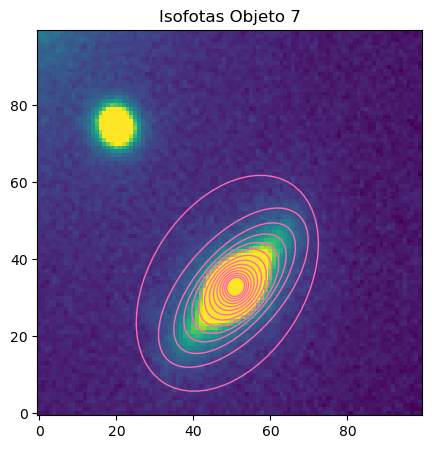

In [77]:
graficar_varias_isofotas(Objeto_7,Lista_isofotas_obj_7,\
                         archivos_array_g,18,46,'Isofotas Objeto 7')

* Isofotas del Objeto 8

In [78]:
Objeto_8 = archivos_array_z[550:650,470:570]

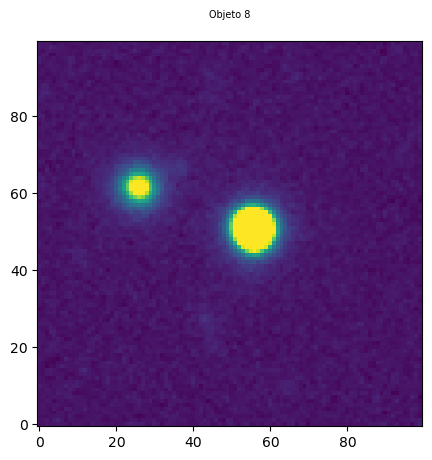

In [79]:
grafricar_1(Objeto_8,'Objeto 8')

* Generamos una elipse de prueba que se acomode al objeto y la graficamos para observar su coincidencia 

In [80]:
Elipse_Prueba_O_8 = generador_de_geometria_isofotas(55.5,51,7.2,0.01,55)

(<matplotlib.patches.Ellipse at 0x213bd6b7c70>,)

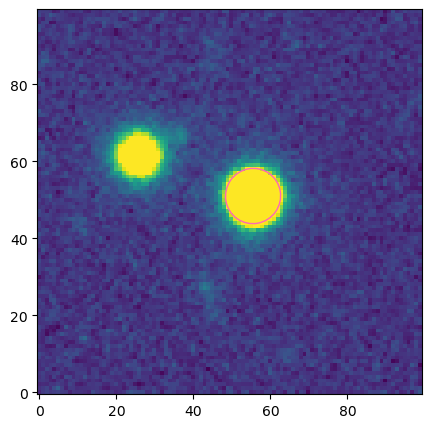

In [81]:
apertura_O_8 = generador_de_una_apertura(Elipse_Prueba_O_8)
plt.figure(figsize=(5,5))
plt.imshow(Objeto_8, origin='lower',\
           vmax=np.mean(archivos_array_z)+np.std(archivos_array_z))
apertura_O_8.plot(color='hotpink')

* Ya teniendo una idea de como es la primera isofota, usando "Ellipse" de "photutils.isophote" en conjunto a la geometría de esta y todo esto iterado un par de veces, obtenemos una visualización de variadas isofotas para el objeto. 

In [82]:
Lista_isofotas_obj_8 = generador_de_isofotas(Objeto_8,Elipse_Prueba_O_8)

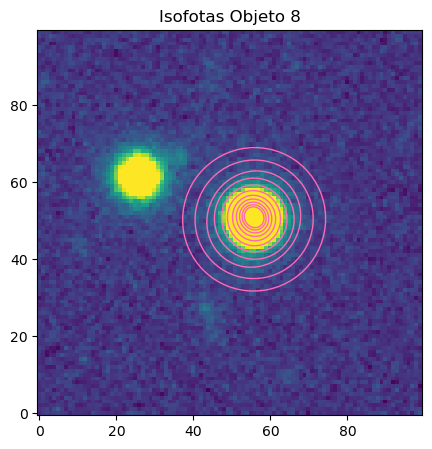

In [83]:
graficar_varias_isofotas(Objeto_8,Lista_isofotas_obj_8,\
                         archivos_array_z,18,39,'Isofotas Objeto 8')

* Isofotas del Objeto 9


In [84]:
Objeto_9 = archivos_array_z[560:660,440:540]

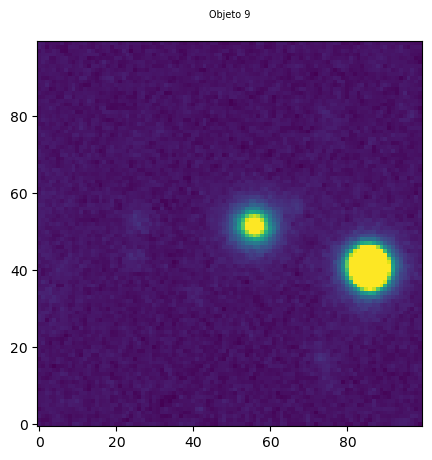

In [85]:
grafricar_1(Objeto_9,'Objeto 9')

* Generamos una elipse de prueba que se acomode al objeto y la graficamos para observar su coincidencia 

In [86]:
Elipse_Prueba_O_9 = generador_de_geometria_isofotas(55.5,51.5,6,0.01,55)

(<matplotlib.patches.Ellipse at 0x213b9186460>,)

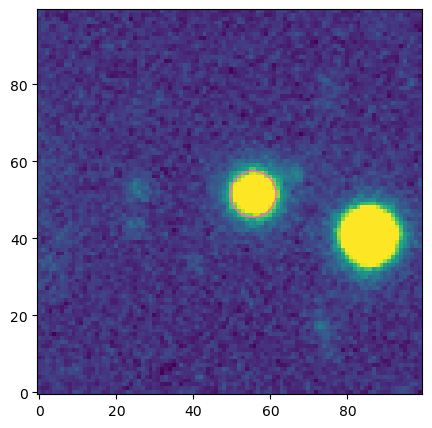

In [87]:
apertura_O_9 = generador_de_una_apertura(Elipse_Prueba_O_9)
plt.figure(figsize=(5,5))
plt.imshow(Objeto_9, origin='lower',\
           vmax=np.mean(archivos_array_z)+np.std(archivos_array_z))
apertura_O_9.plot(color='hotpink')

* Ya teniendo una idea de como es la primera isofota, usando "Ellipse" de "photutils.isophote" en conjunto a la geometría de esta y todo esto iterado un par de veces, obtenemos una visualización de variadas isofotas para el objeto. 

In [88]:
Lista_isofotas_obj_9 = generador_de_isofotas(Objeto_9,Elipse_Prueba_O_9)

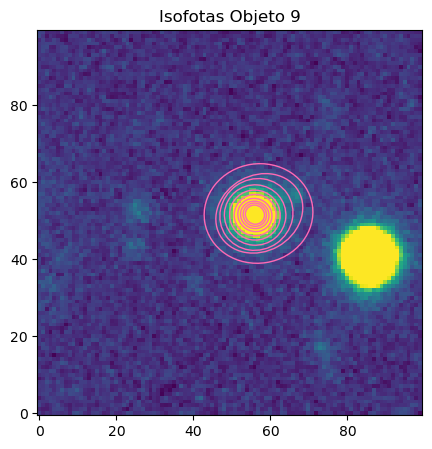

In [89]:
graficar_varias_isofotas(Objeto_9,Lista_isofotas_obj_9,\
                         archivos_array_z,18,38,'Isofotas Objeto 9')